In [5]:
from disent.systems.vae import HParams, VaeSystem
from disent.util import to_numpy, load_model, save_model
from disent.visualize.notebook import *
from disent.dataset import make_ground_truth_dataset
from disent import metrics

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

import imageio
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os
from cachier import cachier as _cachier

# cachier with default values
def cachier(_func_=None, **kwargs):
    defaults = dict(cache_dir='data/cache', pickle_reload=False)
    defaults.update(kwargs)
    decorator = _cachier(**defaults)
    if _func_ is not None:
        return decorator(_func_)
    else:
        return decorator
    
def get_latent_outputs(system, num_samples=1000):
    means, logvars = [], []
    for i, batch in enumerate(DataLoader(system.dataset_train, batch_size=1, shuffle=True)):
        try:
            x, _ = batch
        except:
            x = batch
        z_mean, z_logvar = system.model.encode_gaussian(x.cuda())
        means.append(z_mean.cpu().detach().numpy()[0])
        logvars.append(z_logvar.cpu().detach().numpy()[0])
        if i >= num_samples:
            break
    means, logvars = np.array(means), np.array(logvars)
    return means, logvars #, np.exp(logvars).mean(axis=0)
    
def plot_system_mean_and_var(system, num_samples=100, figsize=(8, 2)):
    means, logvars = get_latent_outputs(system, num_samples)
    
    means_mean, means_std = means.mean(axis=0), means.std(axis=0)
    logvar_mean, logvar_std = logvars.mean(axis=0), logvars.std(axis=0)
    stds = np.exp(logvars) ** 0.5
    std_mean, std_std = stds.mean(axis=0), stds.std(axis=0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    from matplotlib.ticker import MaxNLocator
    
    ax1.set_title('z_mean')
    ax1.set_xlabel('idx')
    ax1.set_ylabel('value')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-2, 2])
    ax1.errorbar(np.arange(len(means_mean)) + 1, means_mean, yerr=means_std)

    ax2.set_title('z_logvar')
    ax2.set_xlabel('idx')
    ax2.set_ylabel('value')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-5, 0])
    ax2.errorbar(np.arange(len(logvar_mean)) + 1, logvar_mean, yerr=logvar_std)
    
    ax3.set_title('exp(z_logvar) ** 0.5')
    ax3.set_xlabel('idx')
    ax3.set_ylabel('value')
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_ylim([-0.05, 0.2])
    ax3.errorbar(np.arange(len(std_mean)) + 1, std_mean, yerr=std_std)
    
    return means_mean, logvar_mean

def train_system(loss='ada-gvae', dataset='dsprites', model='simple-fc', z_size=6, epochs=1, decay=False, steps=None, save_path=None, load_path=None, train=False, try_in_memory=False, batch_size=64):
    hparams = HParams(loss=loss, dataset=dataset, model=model, z_size=z_size, lr=0.001, weight_decay=(0.000001 if decay else 0.0), num_workers=6, batch_size=batch_size, try_in_memory=try_in_memory)
    system = VaeSystem(hparams)
    if load_path:
        # system.load_from_checkpoint(checkpoint_path=PATH)
        system = load_model(system, load_path, cuda=False)
    if train:
        trainer = system.quick_train(epochs=epochs, steps=steps)
        if save_path:
            # trainer.save_checkpoint(save_path)
            save_model(system, save_path)
    return system #, trainer

def notebook_display_image(img, format='png'):
    """
    Display a raw image within an IPython notebook
    - Internally converts the image to bytes
      representing a png image and then displays it.
    """
    assert format in {'png', 'jpg'}, 'Invalid format, must be one of: {"png", "jpg"}'
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"
    from IPython import display
    from imageio import imwrite
    # convert to png and get bytes | https://imageio.readthedocs.io/en/stable/userapi.html
    data = imwrite('<bytes>', to_numpy(img), format=format)
    # diplay png image in notebook | https://github.com/ipython/ipython/issues/10045#issuecomment-522697219
    image = display.Image(data=data, format=format)
    display.display(image)

# Varying Factors

[(10, 'floor_hue'),
 (10, 'wall_hue'),
 (10, 'object_hue'),
 (8, 'scale'),
 (4, 'shape'),
 (15, 'orientation')]


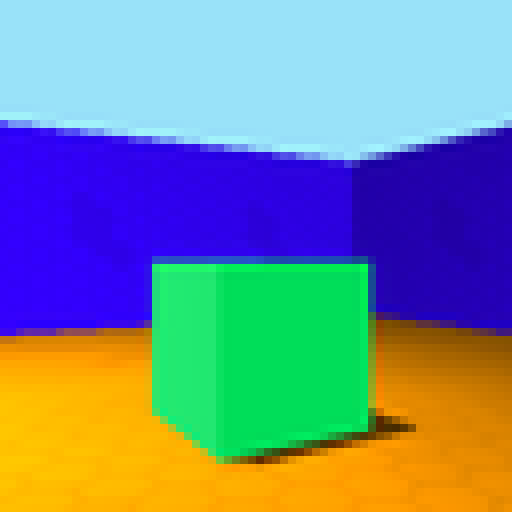

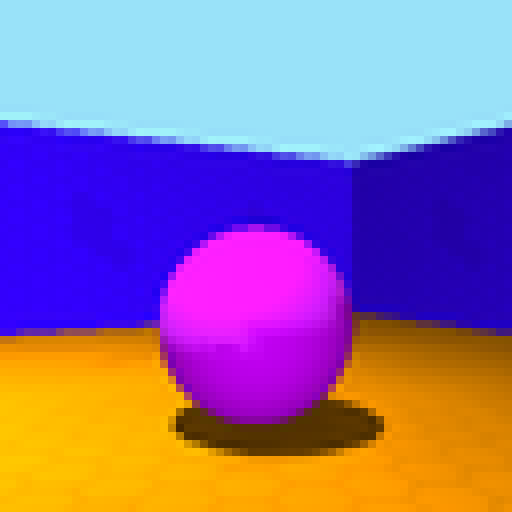

In [2]:
from disent.dataset import Shapes3dData
from pprint import pprint
import cv2

data = Shapes3dData()

# pprint([s for s in dir(data) if not s.startswith('_')])
pprint(list(zip(data.factor_sizes, data.factor_names)))
# pprint(dir(disent.visualize.notebook))


img1 = data[data.pos_to_idx([1,7,4,4,0,0])]
img2 = data[data.pos_to_idx([1,7,8,4,2,0])]

new_size = 512
img1 = cv2.resize(img1, dsize=(new_size, new_size), interpolation=cv2.INTER_NEAREST)
img2 = cv2.resize(img2, dsize=(new_size, new_size), interpolation=cv2.INTER_NEAREST)

notebook_display_image(img1)
notebook_display_image(img2)


# Entangled vs. Disentangled

In [3]:
!ls data/models | grep z6
!echo
!ls data | grep z6

trained-e10-3dshapes-simple-fc-z6-adagvae.ckpt
trained-e10-3dshapes-simple-fc-z6-betavae.ckpt
trained-e10-dsprites-simple-fc-z6-adagvae.ckpt
trained-e10-dsprites-simple-fc-z6-betavae.ckpt

trained-e10-3dshapes-simple-fc-z6-adagvae-decay.ckpt
trained-e10-3dshapes-simple-fc-z6-betavae-decay.ckpt
trained-e10-dsprites-conv-z6-betavae-decay.ckpt
trained-e10-dsprites-simple-fc-z6-adagvae-decay.ckpt
trained-e10-dsprites-simple-fc-z6-betavae-decay.ckpt


[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z6-adagvae.ckpt (cuda: False)


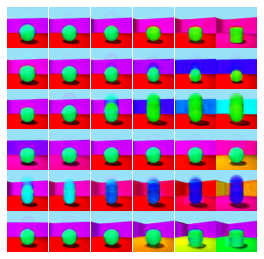

In [8]:

PATH = 'data/models/trained-e10-3dshapes-simple-fc-z6-adagvae.ckpt'
system = train_system(loss='ada-gvae', dataset='3dshapes', epochs=10, model='simple-fc', save_path=None, load_path=PATH, train=False).cuda()
plt_traverse_latent_space(system, num_samples=1, values=6, dimensions=None)

[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z12-adagvae.ckpt (cuda: False)


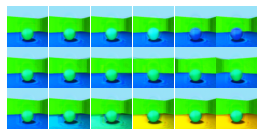

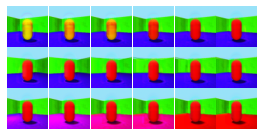

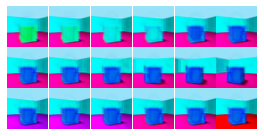

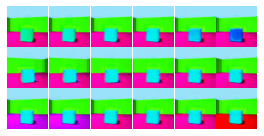

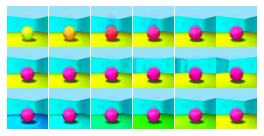

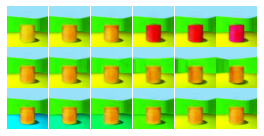

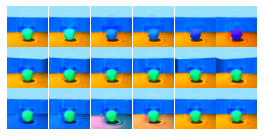

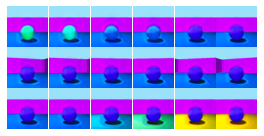

In [87]:
PATH = 'data/models/trained-e10-3dshapes-simple-fc-z12-adagvae.ckpt'
system = train_system(loss='ada-gvae', dataset='3dshapes', z_size=12, epochs=10, model='simple-fc', save_path=None, load_path=PATH, train=False).cuda()

# means, logvars = np.around(plot_system_mean_and_var(system, 1000), 2)
# t = 0.5 * (np.min(logvars) + np.max(logvars))
# indices = np.arange(12)[logvars > t-2]

indices = [0, 1, 2, 5, 6, 7, 8, 10]
indices = [0, 1, 6, 7, 8, 10]
indices = [1, 7, 8]
# indices = [1, 6, 8]

plt_traverse_latent_space(system, num_samples=8, values=6, dimensions=indices)

[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z12-betavae.ckpt (cuda: False)


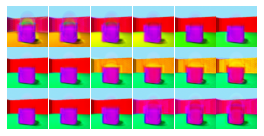

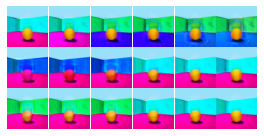

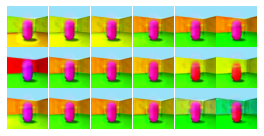

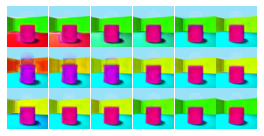

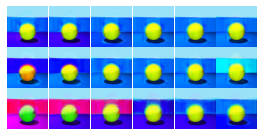

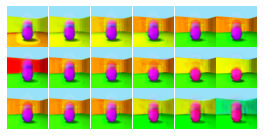

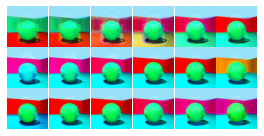

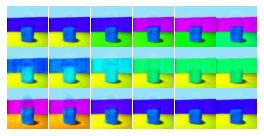

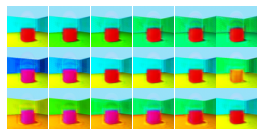

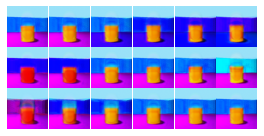

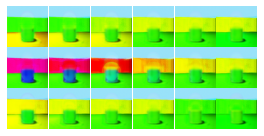

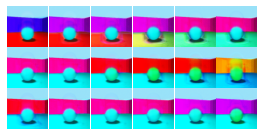

In [81]:
PATH = 'data/models/trained-e10-3dshapes-simple-fc-z12-betavae.ckpt'
system = train_system(loss='beta-vae', dataset='3dshapes', z_size=12, epochs=10, model='simple-fc', save_path=None, load_path=PATH, train=False).cuda()

# means, logvars = np.around(plot_system_mean_and_var(system, 1000), 2)
# t = 0.5 * (np.min(logvars) + np.max(logvars))
# indices = np.arange(12)[logvars < t-1.75]

indices = [0, 2, 3, 5, 7, 8, 9, 10]
indices = [0, 3, 5, 7, 8, 9]
indices = [0, 3, 8]

plt_traverse_latent_space(system, num_samples=12, values=6, dimensions=indices)


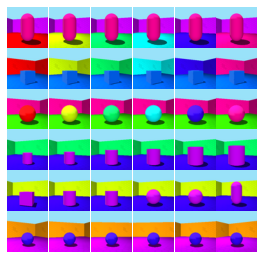

In [84]:
plt_sample_dataset_still_images('3dshapes', 6)

# VARIENCE

In [132]:
!ls data/models | grep 3dshapes | grep e10
!echo

data = []

for (z_size, loss, path) in [
    (12, 'ada-gvae', 'data/models/trained-e10-3dshapes-simple-fc-z12-adagvae.ckpt'),
    (9, 'ada-gvae', 'data/model/trained-e10-3dshapes-simple-fc-z9-adagvae.ckpt'),
    (6, 'ada-gvae', 'data/models/trained-e10-3dshapes-simple-fc-z6-adagvae.ckpt'),
    (3, 'ada-gvae', 'data/models/trained-e10-3dshapes-simple-fc-z3-adagvae.ckpt'),
    (12, 'beta-vae', 'data/models/trained-e10-3dshapes-simple-fc-z12-betavae.ckpt'),
    (9, 'beta-vae', 'data/model/trained-e10-3dshapes-simple-fc-z9-betavae.ckpt'),
    (6, 'beta-vae', 'data/models/trained-e10-3dshapes-simple-fc-z6-betavae.ckpt'),
    (3, 'beta-vae', 'data/models/trained-e10-3dshapes-simple-fc-z3-betavae.ckpt'),
]:
    system = train_system(loss=loss, dataset='3dshapes', model='simple-fc', z_size=z_size, load_path=path, train=False).cuda()
    means, logvars = get_latent_outputs(system, 10000)
    
    logvar_mean, logvar_std = logvars.mean(axis=0), logvars.std(axis=0)
    
    stds = np.exp(logvars) ** 0.5
    std_mean, std_std = stds.mean(axis=0), stds.std(axis=0)
    
    data.extend({
        "z_size": z_size,
        "framework": loss,
        "latent_idx": i,
        "logvar_mean": lm,
        "logvar_std": ls,
        "std_mean": sm,
        "std_std": ss,
    } for (i, lm, ls, sm, ss) in zip(np.arange(len(means)) + 1, logvar_mean, logvar_std, std_mean, std_std))


trained-e10-3dshapes-simple-fc-z12-adagvae.ckpt
trained-e10-3dshapes-simple-fc-z12-betavae.ckpt
trained-e10-3dshapes-simple-fc-z24-adagvae.ckpt
trained-e10-3dshapes-simple-fc-z3-adagvae.ckpt
trained-e10-3dshapes-simple-fc-z3-betavae.ckpt
trained-e10-3dshapes-simple-fc-z6-adagvae.ckpt
trained-e10-3dshapes-simple-fc-z6-betavae.ckpt

[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z12-adagvae.ckpt (cuda: False)
[MODEL]: loaded data/model/trained-e10-3dshapes-simple-fc-z9-adagvae.ckpt (cuda: False)
[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z6-adagvae.ckpt (cuda: False)
[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z3-adagvae.ckpt (cuda: False)
[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z12-betavae.ckpt (cuda: False)
[MODEL]: loaded data/model/trained-e10-3dshapes-simple-fc-z9-betavae.ckpt (cuda: False)
[MODEL]: loaded data/models/trained-e10-3dshapes-simple-fc-z6-betavae.ckpt (cuda: False)
[MODEL]: loaded data/models/trained-e10-3dsh

<Figure size 504x288 with 0 Axes>

(0.007943282347242814, 1.2589254117941673)

Text(0.5, 0, 'Latent Idx')

Text(0, 0.5, 'Standard Deviation')

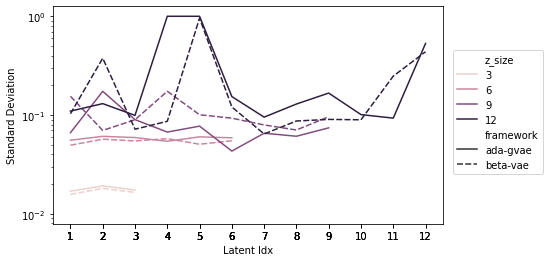

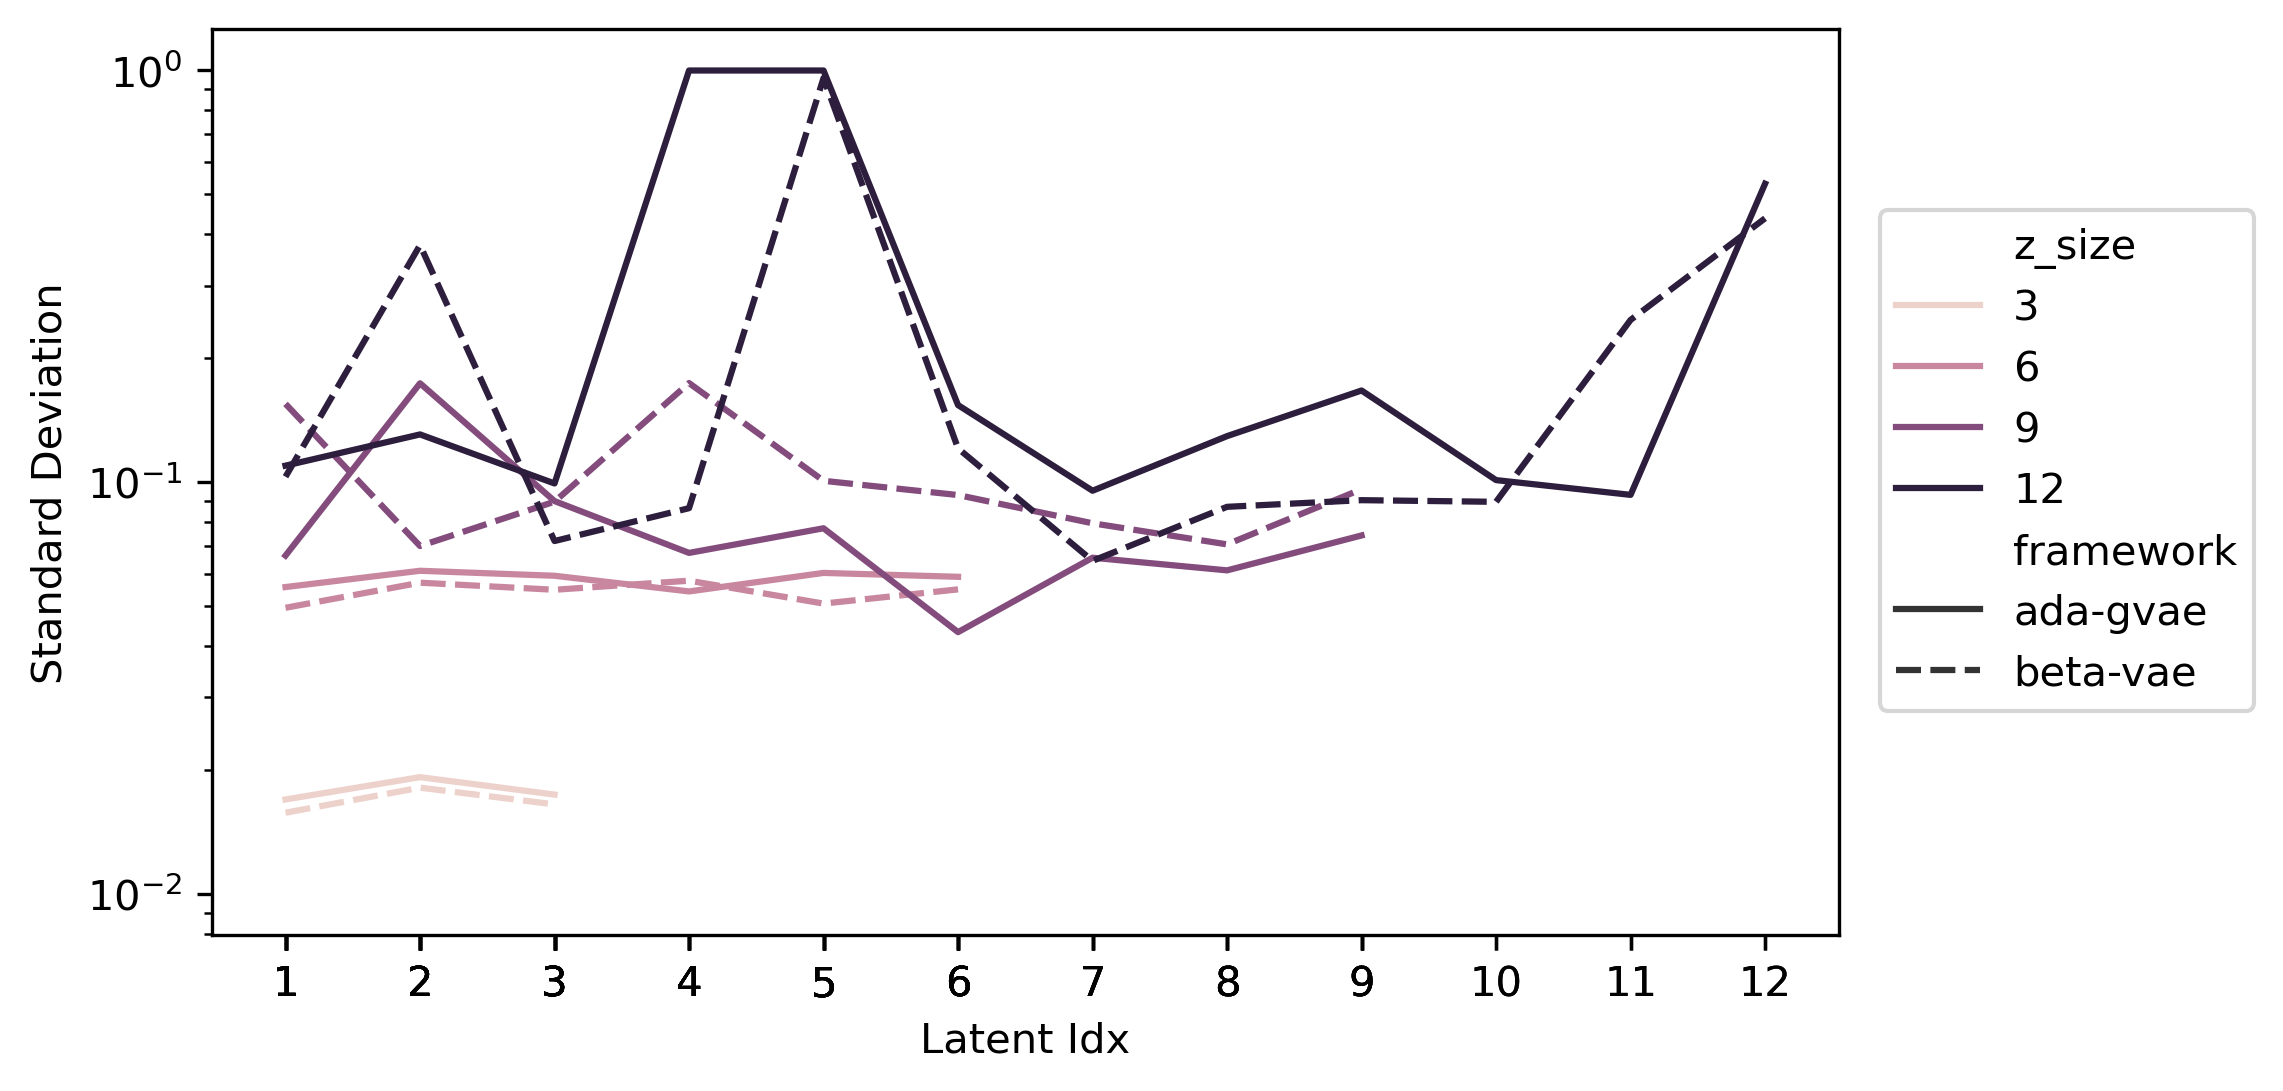

In [177]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data)

plt.figure(figsize=(7, 4))
ax = sns.lineplot(x="latent_idx", y="std_mean", hue='z_size', style='framework', data=df)

ax.set_yscale('log')
ax.set_ylim((pow(10,-2.1), pow(10,0.1)))
ax.set_xticks(df['latent_idx'])
ax.set_xlabel('Latent Idx')
ax.set_ylabel('Standard Deviation')

plt.legend(bbox_to_anchor=(1.025, 0.8), loc=2, borderaxespad=0.)


# ax.errorbar(df["latent_idx"], df['std_mean'], yerr=df['std_std'], fmt=' ')

plt.savefig('latent-plot.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

from imageio import imread
notebook_display_image(imread('latent-plot.png'))

# ax = sns.lineplot(x="latent_idx", y="logvar_mean", hue='z_size', style='framework', data=df)

# Datasets

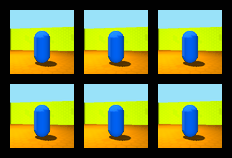

In [37]:
notebook_display_sample_dataset_animation('3dshapes', num_frames=30, fps=10)

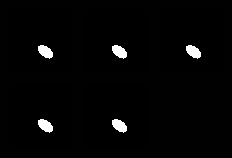

In [14]:
notebook_display_sample_dataset_animation('dsprites', num_frames=30, fps=10)